# Implementing Parameter Shift Rule with Qiskit

Follow the paper [Gradients of parameterized quantum gates using the parameter-shift rule and gate decomposition](https://arxiv.org/abs/1905.13311)

## Import Packages and Dataset Preparation

#### Dataset
- We use the famous dataset : [Iris dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html)

#### Data Preprocessing
1. Use [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) to reduce the dimension from 4 to 2
2. Shift and scale the data to [0,1]

In [9]:
import time
import numpy as np
from sklearn import datasets
from sklearn.decomposition import PCA
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit import Aer, transpile

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)

In [10]:
# load dataset with sklearn
iris = datasets.load_iris()
x_data, y_data = iris.data[:100], iris.target[:100]

# data preprocessing
x_data = PCA(n_components=2).fit_transform(x_data)
x_data = np.transpose(x_data)
for i in range(len(x_data)):
    x_data[i] -= np.min(x_data[i])
    x_data[i] *= np.pi / np.max(x_data[i])
x_data = np.transpose(x_data)

print(f"x_data shape = {x_data.shape} | y_data shape = {y_data.shape}")

x_data shape = (100, 2) | y_data shape = (100,)


## Variational Quantum Circuit

- See [Variational Quantum Circuit](https://pennylane.ai/qml/glossary/variational_circuit.html) for more detail
- We also use the [Data re-uploading technique](https://arxiv.org/abs/1907.02085)

#### VQC(class)
- evaluate: run the simulation with given data and trainable parameters, return the expectation value
- parameter_shift: we use the formula in the original paper $\frac{d}{d\theta}f(\theta)=\frac{1}{2}(f(\theta+\frac{\pi}{2})-f(\theta-\frac{\pi}{2}))$

In [11]:
class VariationalQuantumCircuit:
    def __init__(self, num_qubits, num_layers, ansatz):
        '''Variational Quantum Circuit
        
        Args:
            num_qubits (int): number of qubits, assuming same as the dimension of the data
            num_layers (int): data-reuploading times
            ansatz (function): will return a tuple (x_param, u_param)
                               x_param (array[qiskit.circuit.Parameter]): used for the input of x data
                               u_param (array[qiskit.circuit.Parameter]): used for trainable parameters
        '''

        # setup
        self.num_qubits = num_qubits
        self.num_layers = num_layers
        self.q_circuit  = QuantumCircuit(num_qubits, 1)
        self.x_param, self.u_param = ansatz(self.q_circuit, num_qubits, num_layers)

        # measure the expectation value of the first qubit as the final prediction
        self.q_circuit.measure(0,0)
        self.backend = Aer.get_backend('qasm_simulator')

    def evaluate(self, x, u, shots=1024):
        '''Evaluating the expectation value of the quantum circuit

        Args:
            x (array): x data
            u (array): trainable parameters
        '''

        # construct a dictionary between circuit parameters(qiskit.circuit.Parameter) and values(x and u)
        param = np.concatenate((self.x_param.flatten(), self.u_param.flatten()))
        value = np.concatenate((x.flatten(), u.flatten()))
        dic   = dict(zip(param, value))

        # run simulation
        x_circuit = self.q_circuit.bind_parameters(dic)
        x_compile = transpile(x_circuit, self.backend)
        job       = self.backend.run(x_compile, shots=shots)
        counts    = job.result().get_counts(x_compile)

        # expectation value = (0*counts['0'] + 1*counts['1'])/(shots)
        return counts['1'] / shots

    def parameter_shift(self, x, u):
        '''Implementing the parameter shift rule

        Args:
            x (array): x data
            u (array): trainable parameters
        '''

        # record gradients with the same shape as the trainable parameters
        gradients = np.zeros(np.shape(u))
        for i in range(u.shape[0]):
            for j in range(u.shape[1]):
                u_plus, u_minus = np.copy(u), np.copy(u)
                u_plus[i][j]  += np.pi / 2
                u_minus[i][j] -= np.pi / 2
                gradients[i][j] = (self.evaluate(x, u_plus)-self.evaluate(x, u_minus)) / 2
        return gradients

## Ansatz

We use an famous and easy ansatz, constructed by rotation gates. See the circuit.draw() below for the circuit image.

In [12]:
def rotation_circuit(q_circuit, num_qubits, num_layers):
    '''Construct the quantum circuit
    
    Args:
        q_circuit (qiskit.circuit.QuantumCircuit): quantum circuit to be built up
        num_qubits (int): number of qubits, assuming same as the dimension of the data
        num_layers (int): data-reuploading times
    Return:
        x_param (array[qiskit.circuit.Parameter]): used for the input of x data
        u_param (array[qiskit.circuit.Parameter]): used for trainable parameters
    '''

    x_param = np.array([Parameter(f"x_{i}") for i in range(num_qubits)])
    u_param = np.array([[Parameter(f"u_{l}_{i}") for i in range(3*num_qubits)] for l in range(num_layers)])

    for l in range(num_layers):
        # data re-upload for each l
        for i in range(num_qubits):
            # encode the x data with rotation gates
            q_circuit.rx(x_param[i], i)
            q_circuit.ry(u_param[l][3*i+0], i)
            q_circuit.rx(u_param[l][3*i+1], i)
            q_circuit.ry(u_param[l][3*i+2], i)
        for i in range(num_qubits):
            # add controlled-z gate for entanglement
            if i != num_qubits - 1 or num_qubits > 2:
                q_circuit.h((i+1)%num_qubits)
                q_circuit.cx(i%num_qubits, (i+1)%num_qubits)
                q_circuit.h((i+1)%num_qubits)
        q_circuit.barrier(range(num_qubits))
    return x_param, u_param

## Model and Training

- Use [stochastic gradient method](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) to update the trainable parameters
- Initialize the trainable parameters with uniformly randomize in $[0, 2\pi]$
- Use square loss function $L(x,\theta) = (f(x,\theta)-y)^2$, the gradient is $\frac{\partial L}{\partial \theta_i}=2(f(x,\theta)-y)\frac{\partial f}{\partial \theta_i}$ where $\frac{\partial f}{\partial \theta_i}$ can be found using parameter shift rule

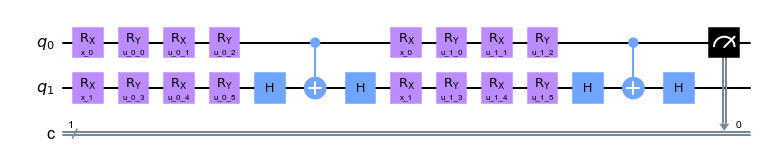

In [13]:
num_qubits    = x_data.shape[1]
num_layers    = 2
num_epochs    = 20 # number of epochs
num_batch     = 16 # number of data per batch
learning_rate = 0.25 # learning_rate for stochastic gradient descent

vqc = VariationalQuantumCircuit(num_qubits, num_layers, rotation_circuit)
vqc.q_circuit.draw('mpl', plot_barriers=False, scale=1)

In [14]:
def square_loss(y_prediction, y_true):
    return np.mean((y_prediction - y_true) ** 2)

def square_loss_gradient(x, y):
    global thetas
    return 2 * (vqc.evaluate(x, thetas) - y) * vqc.parameter_shift(x, thetas)

In [15]:
npy_thetas = f"thetas_q{num_qubits}_l{num_layers}.npy" # for saving trained thetas
npy_record = f"record_q{num_qubits}_l{num_layers}.npy" # for saving training record

try:
    thetas = np.load(npy_thetas, allow_pickle=True)
    record = np.load(npy_record, allow_pickle=True)
    print("Trained files found, successfully loaded.")
except:
    thetas  = 2 * np.pi * np.random.rand(*vqc.u_param.shape) # trainable parameters
    record  = [] # record loss and accuracy in every epoch
    t_start = time.time()

    for epoch in range(num_epochs+1):
        if epoch != 0:
            # randomly select data as batch data
            batch_indices    = np.random.choice(np.arange(len(x_data)), num_batch, replace=True)
            x_batch, y_batch = x_data[batch_indices], y_data[batch_indices]
            
            # stochastic gradient descent
            gradient = np.array([square_loss_gradient(x_batch[i], y_batch[i]) for i in range(len(x_batch))])
            thetas  -= learning_rate * np.mean(gradient, axis=0)

        # calculating mean loss and accuracy
        y_pred   = np.array([vqc.evaluate(x_data[i], thetas) for i in range(len(x_data))])
        loss     = square_loss(y_pred, y_data)
        accuracy = np.mean((y_pred > 0.5) == y_data)

        record.append({'loss':loss, 'accuracy':accuracy})
        print(f"Epoch {epoch} : Loss = {loss:.4f} | Accuracy = {accuracy:.2f}")

    np.save(npy_thetas, thetas, allow_pickle=True)
    np.save(npy_record, record, allow_pickle=True)
    t_end = time.time()
    print(f"Time = {t_end-t_start:.2f} seconds")

Trained files found, successfully loaded.


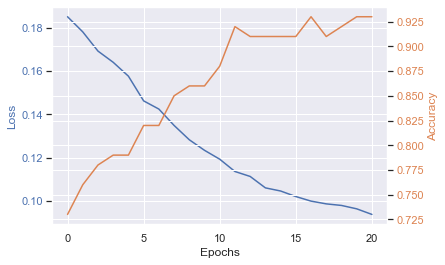

In [16]:
sns.set_theme()
fig, ax_loss = plt.subplots()
ax_accuracy  = ax_loss.twinx()
ax_loss.set_xlabel("Epochs")

color_loss = 'C0'
ax_loss.plot(range(len(record)), [record[i]['loss'] for i in range(len(record))], color=color_loss)
ax_loss.set_xticks([5*i for i in range(len(record))])
ax_loss.set_ylabel("Loss", color=color_loss)
ax_loss.tick_params(axis='y', labelcolor=color_loss)

color_accuracy = 'C1'
ax_accuracy.plot(range(len(record)), [record[i]['accuracy'] for i in range(len(record))], color_accuracy)
ax_accuracy.set_ylabel("Accuracy", color=color_accuracy)
ax_accuracy.tick_params(axis='y', labelcolor=color_accuracy)